## Trial01 : Laplacian variance
### 목표: focused image와 blurred image 사이의 수치적인 차이를 구분하기

+ 시도1) LBP -> Lapla_Var
+ 시도2) LBP -> Lapla_Var -> Gaussian blur

 단, 육안으로 구분이 뚜렷한 이미지임에도 수치적인 변화가 크지 않는 경우가 있다.

In [2]:
# 필요한 라이브러리 import

import math
import numpy as np
import cv2
import matplotlib.pyplot as plt #그래프
from imutils.video import VideoStream


In [3]:
# LBP 알고리즘

def im2double(im):
	min_val = np.min(im.ravel()) # ravel() 다차원 -> 1차원
	max_val = np.max(im.ravel())
	out = (im.astype('float') - min_val) / (max_val - min_val)
	return out


def s(x):
	temp = x>0
	return temp.astype(float)


# LBP 알고리즘
def lbpCode(im_gray, threshold):
	width, height = im_gray.shape
	interpOff = math.sqrt(2)/2
	I = im2double(im_gray)
	pt = cv2.copyMakeBorder(I,1,1,1,1,cv2.BORDER_REPLICATE)
	right = pt[1:-1, 2:]
	left = pt[1:-1, :-2]
	above = pt[:-2, 1:-1]
	below = pt[2:, 1:-1];
	aboveRight = pt[:-2, 2:]
	aboveLeft = pt[:-2, :-2]
	belowRight = pt[2:, 2:]
	belowLeft = pt[2:, :-2]
	interp0 = right
	interp1 = (1-interpOff)*((1-interpOff) * I + interpOff * right) + interpOff *((1-interpOff) * above + interpOff * aboveRight)

	interp2 = above;
	interp3 = (1-interpOff)*((1-interpOff) * I + interpOff * left ) + interpOff *((1-interpOff) * above + interpOff * aboveLeft)

	interp4 = left;
	interp5 = (1-interpOff)*((1-interpOff) * I + interpOff * left ) + interpOff *((1-interpOff) * below + interpOff * belowLeft)

	interp6 = below;
	interp7 = (1-interpOff)*((1-interpOff) * I + interpOff * right ) + interpOff *((1-interpOff) * below + interpOff * belowRight) 

	s0 = s(interp0 - I-threshold)
	s1 = s(interp1 - I-threshold)
	s2 = s(interp2 - I-threshold)
	s3 = s(interp3 - I-threshold)
	s4 = s(interp4 - I-threshold)
	s5 = s(interp5 - I-threshold)
	s6 = s(interp6 - I-threshold)
	s7 = s(interp7 - I-threshold)
	LBP81 = s0 * 1 + s1 * 2+s2 * 4   + s3 * 8+ s4 * 16  + s5 * 32  + s6 * 64  + s7 * 128
	LBP81.astype(int)

	U = np.abs(s0 - s7) + np.abs(s1 - s0) + np.abs(s2 - s1) + np.abs(s3 - s2) + np.abs(s4 - s3) + np.abs(s5 - s4) + np.abs(s6 - s5) + np.abs(s7 - s6)
	LBP81riu2 = s0 + s1 + s2 + s3 + s4 + s5 + s6 + s7
	LBP81riu2[U > 2] = 9;

	return LBP81riu2



def lbpSharpness(im_gray, s, threshold):
	lbpmap  = lbpCode(im_gray, threshold)
	window_r = (s-1)//2;
	h, w = im_gray.shape[:2]
	map =  np.zeros((h, w), dtype=float)
	lbpmap_pad = cv2.copyMakeBorder(lbpmap, window_r, window_r, window_r, window_r, cv2.BORDER_REPLICATE)

	lbpmap_sum = (lbpmap_pad==6).astype(float) + (lbpmap_pad==7).astype(float) + (lbpmap_pad==8).astype(float) + (lbpmap_pad==9).astype(float)
	integral = cv2.integral(lbpmap_sum);
	integral = integral.astype(float)

	map = (integral[s-1:-1, s-1:-1]-integral[0:h, s-1:-1]-integral[s-1:-1, 0:w]+integral[0:h, 0:w])/math.pow(s,2);

	return map

### LBP -> Lapla

폴더로부터 이미지 읽어오기

-> 각 이미지를 LBP 처리하기

-> LBP 처리 후 Laplacian variance

-> x:frame, y:lapla로 그래프 출력하기

> 솔직히 그냥 original image에 laplacian 먹이는 게 아웃풋 제일 낫다

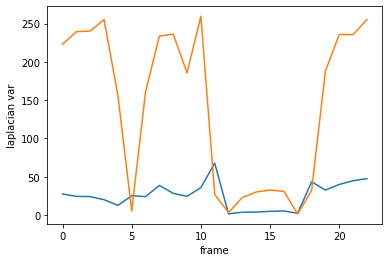

In [11]:
import glob
import itertools

# 폴더로부터 이미지 읽어오기

def getFilenames(exts):
       fnames = [glob.glob(ext) for ext in exts]
       fnames = list(itertools.chain.from_iterable(fnames))
       return fnames
    
# 이미지 경로 지정

exts = ["C:/Users/hannie/Desktop/image20/*.jpg"]
res = getFilenames(exts)
res.sort()
lbp_y=[]; org_y=[]

# 각 이미지를 LBP 처리하는 과정을 반복하기

for img in res:
    
    # LBP 적용
    frame = cv2.imread(img)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    sharpness_map = lbpSharpness(frame_gray, 21, 0.016)
    sharpness_map = (sharpness_map - np.min(sharpness_map)) / (np.max(sharpness_map - np.min(sharpness_map)))
    sharpness_map = (sharpness_map * 255).astype("uint8")
    lbp = np.stack((sharpness_map,) , -1)
    
    # 이미지 창으로 띄우기
#     cv2.imshow('frame',frame)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    # LBP 처리 후 라플라시안 

    laplacian_var = cv2.Laplacian(lbp, cv2.CV_64F).var()
    lbp_y.append(laplacian_var)
    
    # LBP를 거치기 전 original 이미지에 라플라시안
    laplacian_var1 = cv2.Laplacian(frame, cv2.CV_64F).var()    
    org_y.append(laplacian_var1)
    
    
# print(lbp_y) # 행렬로 출력

# plt 그래프로 출력하기
x = np.arange(0,len(lbp_y))
plt.plot(x,lbp_y)
plt.plot(x,org_y) 
plt.xlabel('frame')
plt.ylabel('laplacian var')
plt.grid()
plt.show()

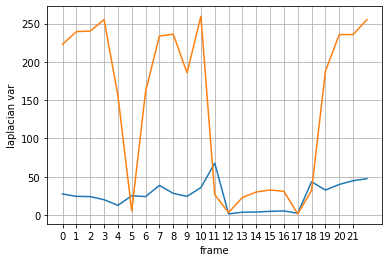

In [13]:
plt.plot(x,lbp_y)
plt.plot(x,org_y) 
plt.xticks(np.arange(0,22))
plt.xlabel('frame')
plt.ylabel('laplacian var')
plt.grid()
plt.show()

### LBP -> +Gaussian -> Lapla 

결과가 완전 엉망으로 나온다..

4.183087757233043


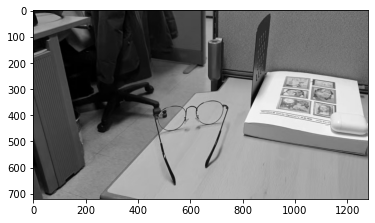

3.9948597329975635


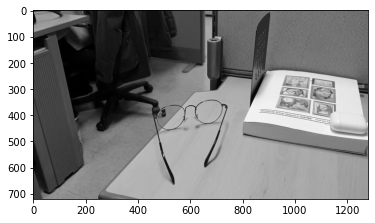

3.864686097367606


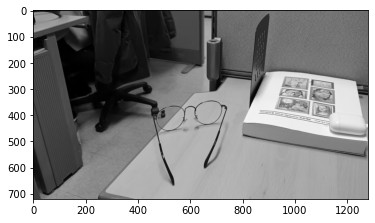

3.2739466986762142


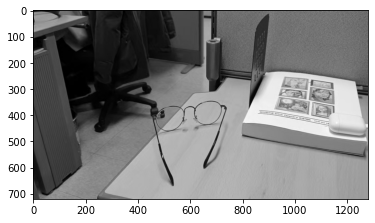

2.496967408352133


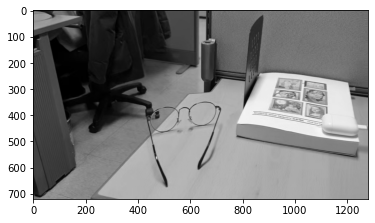

4.092945945145173


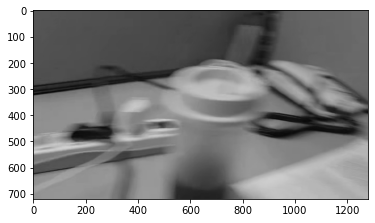

4.243597522046832


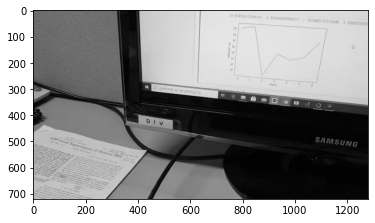

5.730636772325306


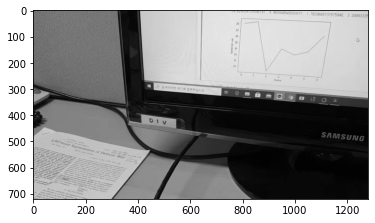

4.949014235507115


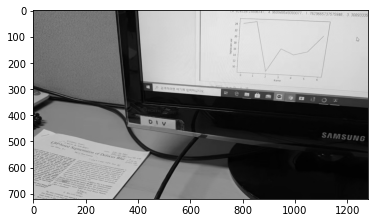

4.494849461006825


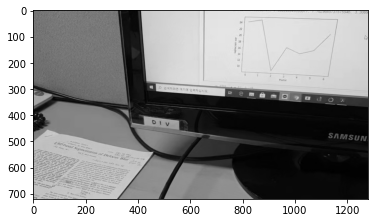

5.310477477508121


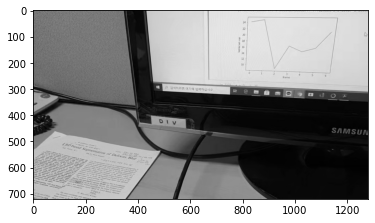

8.14551350600514


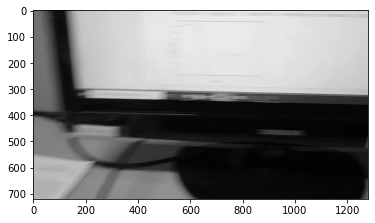

0.23420138850741914


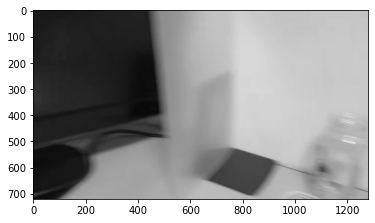

0.8023535123177516


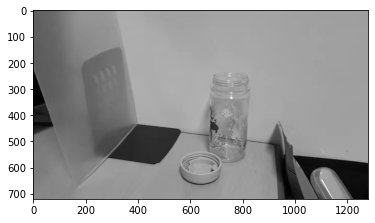

0.8555696611934241


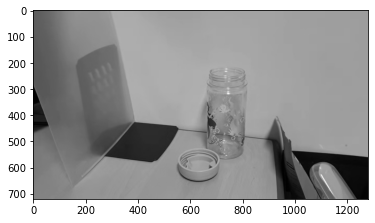

0.9934461714379585


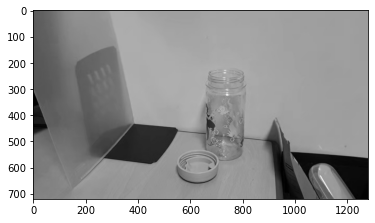

1.106911884053548


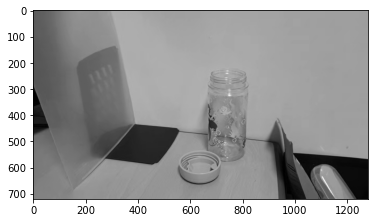

0.44574001736111113


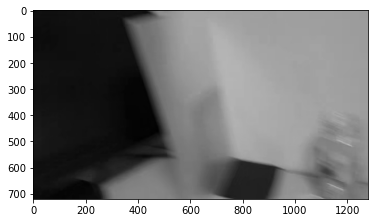

6.22597623087565


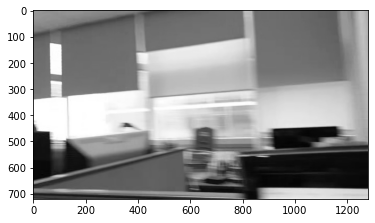

5.0696909450201355


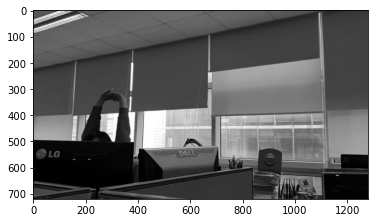

5.946710202957672


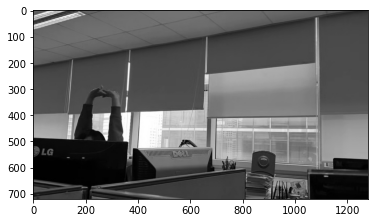

6.556777535613964


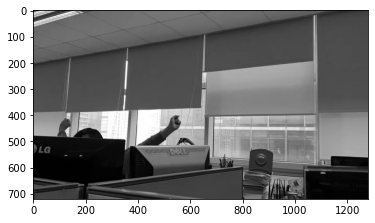

6.757149339082507


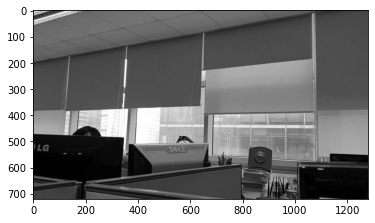

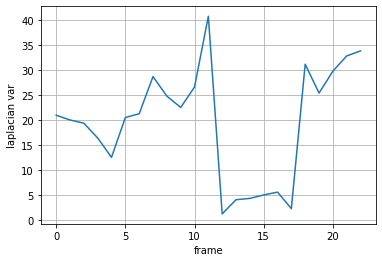

In [9]:
import glob
import itertools

# 폴더로부터 이미지 읽어오기

def getFilenames(exts):
       fnames = [glob.glob(ext) for ext in exts]
       fnames = list(itertools.chain.from_iterable(fnames))
       return fnames
    
# 이미지 경로 지정

exts = ["C:/Users/hannie/Desktop/image20/*.jpg"]
res = getFilenames(exts)
res.sort()
lbp_y=[]; org_y=[]

# 각 이미지를 LBP 처리하는 과정을 반복하기

for img in res:
    
    # LBP 적용
    frame = cv2.imread(img)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    sharpness_map = lbpSharpness(frame_gray, 21, 0.016)
    sharpness_map = (sharpness_map - np.min(sharpness_map)) / (np.max(sharpness_map - np.min(sharpness_map)))
    sharpness_map = (sharpness_map * 255).astype("uint8")
    lbp = np.stack((sharpness_map,) , -1)
    
    
    # 이미지 창으로 띄우기
#     cv2.imshow('frame',frame)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    # 가우시안 블러
    blur = cv2.GaussianBlur(lbp, (3,3), 0)
    
    # 라플라시안
    laplacian_var = cv2.Laplacian(blur, cv2.CV_64F).var()
    lbp_y.append(laplacian_var)
    print(laplacian_var)
    plt.imshow(frame, 'gray')
    plt.show()
    # LBP를 거치기 전 original 이미지에 라플라시안
#     laplacian_var1 = cv2.Laplacian(frame, cv2.CV_64F).var()    
#     org_y.append(laplacian_var1)
    
    
# print(lbp_y) # 행렬로 출력

# plt 그래프로 출력하기
x = np.arange(0,len(lbp_y))
y = 5*np.array(lbp_y)
plt.plot(x,y)
# plt.plot(x,org_y) 
plt.xlabel('frame')
plt.ylabel('laplacian var')
plt.grid()
plt.show()



### Video에서 image 캡처

In [12]:
## section 1 ##
## Video Reading ##

cap = cv2.VideoCapture('focus4.mp4') # 영상의 이미지를 연속적으로 캡처
count = 0

# 영상에서 전체 프레임 중 1/20만 가져와 저장    
# => 전체 프레임으로 코드를 진행할 때 너무 느리기 때문.


if cap.isOpened():
    while True:
        
        ret, frame = cap.read()
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # 흑백으로 전환
        
        
        if(int(cap.get(1)) % 20 == 0): #10도 너무 느려진다. 20이 나을 듯
            print('Saved frame number : ' + str(int(cap.get(1))))
            cv2.imwrite("C:/Users/hannie/Desktop/image20/frame%d.jpg" % count, frame_gray)
            count += 1
            
            sharpness_map = lbpSharpness(frame_gray, 21, 0.032)
            sharpness_map = (sharpness_map - np.min(sharpness_map)) / (np.max(sharpness_map - np.min(sharpness_map)))
        
            sharpness_map = (sharpness_map * 255).astype("uint8")
            concat = np.stack((sharpness_map,) * 3, -1)
            
            cv2.imshow('concat', concat)
            cv2.waitKey(20) # 프레임이 넘어가는 시간
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
                       

cap.release()
cv2.destroyAllWindows()



Saved frame number : 20
Saved frame number : 40
Saved frame number : 60
Saved frame number : 80
Saved frame number : 100
Saved frame number : 120
Saved frame number : 140
Saved frame number : 160
Saved frame number : 180
Saved frame number : 200
Saved frame number : 220
Saved frame number : 240
Saved frame number : 260
Saved frame number : 280
Saved frame number : 300
Saved frame number : 320
Saved frame number : 340
Saved frame number : 360


<ipython-input-12-149c31e526ed>:24: RuntimeWarning: invalid value encountered in true_divide
  sharpness_map = (sharpness_map - np.min(sharpness_map)) / (np.max(sharpness_map - np.min(sharpness_map)))


Saved frame number : 380
Saved frame number : 400
Saved frame number : 420
Saved frame number : 440
Saved frame number : 460


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-9d_dfo3_\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [27]:

# for i in exts:
#     frame = cv2.imread(i,cv2.IMREAD_COLOR)
#     laplacian_var = cv2.Laplacian(frame, cv2.CV_64F).var()
#     print(laplacian_var)
#     if laplacian_var < 5:
#         print("Blurry")


# for i,frame in enumerate(frames.items()):
#     plt.subplot(1,2,i+1)
#     laplacian_var = cv2.Laplacian(frame, cv2.CV_64F).var()
#     plt.title('Blur: '+str(laplacian_var))
#     plt.imshow(frame, cmap = 'gray')
# plt.show()

# cv2.imshow("frame",frame)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# if laplacian_var < 5:
#     print("Blurry")


# frame = cv2.imread("frame6.jpg",cv2.IMREAD_COLOR)
laplacian_var = cv2.Laplacian(lbp, cv2.CV_64F).var()
print(laplacian_var)

8.02663273399142


In [1]:
## section 1 ##
# q 키는 바로 꺼지는데 자동으로 놔두면 에러가 남.

cap = cv2.VideoCapture('focus3.mp4') # 영상의 이미지를 연속적으로 캡처
count = 0

    
while (cap.isOpened()):
    
    ret, frame = cap.read() # 비디오를 한 프레임씩 읽는다
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if not ret:
        print("The End")
        break
        
    cv2.imshow('frame', gray_frame)

    if(int(cap.get(1)) % 20 == 0):
        print('Saved frame number : ' + str(int(cap.get(1))))
        cv2.imwrite("C:/Users/hannie/Desktop/images/frame%d.jpg" % count, gray_frame)
        count += 1

    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


NameError: name 'cv2' is not defined

In [5]:
# initialize the video stream and allow the camera sensor to warm up

print("[INFO] starting video stream...")

vs = VideoStream('focus3.mp4').start()

# loop over the frames from the video stream
while True:
    
    frame = vs.read()
#     frame = imutils.resize(frame, width=500)
    # grab the frame from the threaded video stream and resize it

    # convert the frame to grayscale and detect blur in it
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    sharpness_map = lbpSharpness(frame_gray, 21, 0.032)
    sharpness_map = (sharpness_map - np.min(sharpness_map)) / (np.max(sharpness_map - np.min(sharpness_map)))
    sharpness_map = (sharpness_map * 255).astype("uint8")
    lbp = np.stack((sharpness_map,) , -1)
    
    laplacian_var = cv2.Laplacian(lbp, cv2.CV_64F).var()
    print(laplacian_var)
#     if laplacian_var < 5:
#         blurry = True

#     if 
== True:
#         color = (0, 0, 255)
#         text = "Blurry ({:.4f})"
#     else: 
#         co d lor = (0, 255, 0)
#         text = "Not Blurry ({:.4f})"
        
#     color = (0, 0, 255) if blurry else (0, 255, 0)
#     text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
#     text = text.format(laplacian_var)
#     cv2.putText(frame, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
#     concat = np.concatenate((frame, np.stack((sharpness_map,) * 3, -1)), axis=1)

#     cv2.imshow('concat', concat)
    cv2.imshow('output', lbp)
    cv2.waitKey(10) # 프레임이 넘어가는 시간
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
cv2.dstroyAllWindows()
vs.stop()
        

[INFO] starting video stream...
7.438435329065203
19.69502601792606


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-9d_dfo3_\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
## section 2 ##
# 폴더 내 이미지 읽기

import glob

images = glob.glob('C:/Users/hannie/Desktop/images/*.jpg')

count = 0
for file in images:
    img = cv2.imread(file)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    print('frame%d :' % count); print(laplacian_var)  
    count += 1
    cv2.imshow('img',img)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()